<function matplotlib.pyplot.show(close=None, block=None)>

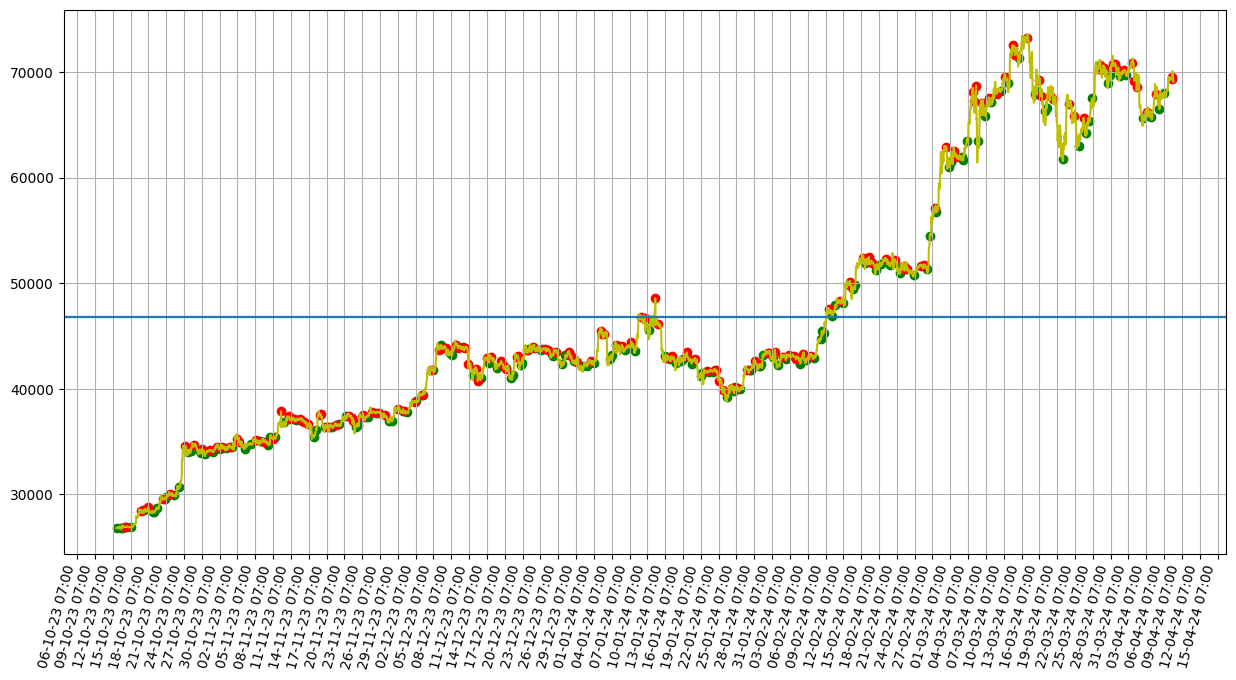

In [72]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 25
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 24
std_mult = 10000000
z_aprox = 0.0000000001

##################################################################################################################################
# Descarga y limpieza de datos de X días atrás a hoy.
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1h','180 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

# initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 05:48:00','%Y-%m-%d %H:%M:%S')].index.item() #+ rango
# final_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-06 05:47:00','%Y-%m-%d %H:%M:%S')].index.item() #- rango

lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
mm_points_idx = []
pmin = 0
pmax = 0

for j in range(0,len(indices_min_max)):
    PMSD = indices_min_max[j]
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*800000000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*30000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*800000000)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*30000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*800000000)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*30000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        max_points_idx.append(pmax_idx)
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*800000000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*30000) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*800000000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*30000) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*800000000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*30000) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        min_points_idx.append(pmin_idx)
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
close_points_max = []
close_points_min = []
for lista in [max_points_idx,min_points_idx]:
    for i in range(len(lista)-1):
        if lista[i+1]-lista[i] <= 2:
            if lista == max_points_idx:
                close_points_max.append(i+1)
            else:
                close_points_min.append(i+1)
    if lista == max_points_idx:
        for idx in sorted(close_points_max,reverse=True):
            del lista[idx]
    else:
        for idx in sorted(close_points_min,reverse=True):
            del lista[idx]

######################################################################
# Ahora ya podemos visualizar los resultados con el siguiente código.
######################################################################
mp = recent_data.Open[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='y')
# plt.plot(recent_data.Tiempo[initial_date_index-100:final_date_index],recent_data.PD_Interpolacion[initial_date_index-100:final_date_index].multiply(30000)+mp,'purple')
# plt.plot(recent_data.Tiempo[initial_date_index-100:final_date_index],recent_data.SD_Interpolacion[initial_date_index-100:final_date_index].multiply(800000000)+mp,color='k')
# plt.plot(recent_data.Tiempo[initial_date_index-100:final_date_index],recent_data.TD_Interpolacion[initial_date_index-100:final_date_index].multiply(30000000000000)+mp,color='b')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=72))
plt.gcf().autofmt_xdate()

# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
plt.show

In [71]:
pmax_df = recent_data.iloc[max_points_idx].iloc[:,:2]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].iloc[:,:2]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=1)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.sort_index()
del_idx = []
vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 1
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits += (-1)*(vc_df.Diferencia_Precio_USDT[i+1])
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_29448\2566828253.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 1


217359.01000000004

In [67]:
vc_df

,index,Tiempo,Open,Accion,Diferencia_Precio_USDT
0,45,2024-03-10 12:00:00,69568.45,V,NaN
1,58,2024-03-11 01:00:00,68095.99,C,-1472.46
2,79,2024-03-11 22:00:00,72517.32,V,4421.33
3,101,2024-03-12 20:00:00,71349.99,C,-1167.33
4,133,2024-03-14 04:00:00,73267.08,V,1917.09
5,166,2024-03-15 13:00:00,67915.00,C,-5352.08
6,182,2024-03-16 05:00:00,69011.01,V,1096.01
7,206,2024-03-17 05:00:00,66351.75,C,-2659.26
8,228,2024-03-18 03:00:00,67764.25,V,1412.50
9,280,2024-03-20 07:00:00,61750.00,C,-6014.25


In [50]:
recent_data.describe()

,Open,High,Low,Close,Volume,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,719.000000,707.000000,7.060000e+02,6.940000e+02,6.930000e+02,6.810000e+02
mean,68283.028639,68590.477125,67944.846639,68284.214014,2071.932232,68283.308089,0.000428,0.000353,-8.188131e-09,-1.103473e-08,-7.280003e-13,-3.666177e-13
std,2516.437965,2475.915018,2568.734910,2516.703539,1686.352808,2466.744299,0.035246,0.031860,1.289561e-06,1.113074e-06,5.766969e-11,4.860875e-11
min,61549.540000,61774.250000,60775.000000,61549.530000,290.473970,62334.117778,-0.102463,-0.077491,-3.613669e-06,-2.913666e-06,-1.861926e-10,-1.412233e-10
25%,66473.812500,66798.980000,66108.282500,66473.812500,980.618218,66353.075991,-0.019169,-0.017583,-8.709752e-07,-7.923989e-07,-4.364100e-11,-3.569067e-11
50%,68314.000000,68600.000000,68121.395000,68313.990000,1531.074945,68303.089880,0.000141,-0.000408,-1.005472e-07,-1.209257e-07,3.065856e-12,3.176380e-12
75%,70100.870000,70321.772500,69850.520000,70100.875000,2745.487783,70080.453962,0.020293,0.018815,7.891837e-07,6.898711e-07,3.838542e-11,3.284490e-11
max,73577.350000,73777.000000,73215.140000,73577.350000,13730.756002,73309.885053,0.135051,0.099472,3.907838e-06,3.207248e-06,1.501205e-10,1.056100e-10
